### Цель

Обучить baseline модель для A321-neo (VQ-BGU, VQ-BDU) **на выбранных параметрах газодинамики** \
и сравнить с предыдущей точностью моделей 

Список параметров, отмеченных Д. Шманатовым как важные:

`LWAI, LNAI, LPRV, LHPV, XF, RHPV, RPRV, RNAI, RWAI, ALT, MN, TAT, N1A, N2A, FF, EGT, NF`

Я убираю L и R, потому что они имют смысл только в отчёте ВС (left-hand/right-hand), а мы работаем с отчётами по конкретному двигателю. \
В итоге получаем такой список параметров: 

`wai, nai, prv, hpv, xf, alt, mn, tat, n1a, n2a, ff, egt, nf`

| Параметр | Расшифровка                          |
|----------|--------------------------------------|
| WAI      | Wing AntiIce Valve Position 
| NAI      | Nacelle AntiIce Valve Position 
| PRV      | PRV (Pressure Relief Valve) Position
| HPV      | HPV (High Pressure Valve) Position 
| XF       | Cross Feed Valve Position 
| ALT	     | Standard Altitude (1013 mbar) 
| MN	     | Mach Number  
| TAT	     | Total Air Temperature from the aircraft  
| N1A	     | Engine Low Pressure Module Speed, Selected  
| N2A	     | Engine High Pressure Module Speed, Selected 
| FF	     | Engine Fuel Flow 
| EGT	     | Selected Cockpit Exhaust Gas Temperature from Engine
| NF       | Fan Speed  

In [35]:
selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

### Подготовка

In [36]:
import pandas as pd

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('p5 > 0 and p25 > 0')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('p5 > 0 and p25 > 0')

dataset = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts')

dataset = dataset[dataset['acnum'].isin(fleet)].dropna(subset=['egtm'])

In [37]:
dataset[selected_params].describe(percentiles=[])

,wai,nai,prv,hpv,xf,alt,mn,tat,n1a,n2a,ff,egt,nf
count,3579.0,3579.000000,3579.000000,3579.0,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000
mean,0.0,0.106734,0.559654,0.0,0.008382,2095.242526,0.271456,10.836602,85.026289,90.927896,3435.789327,894.293574,85.034624
std,0.0,0.308818,0.496498,0.0,0.091183,803.399830,0.015594,12.534836,3.573045,2.370068,334.877250,59.384915,3.569845
min,0.0,0.000000,0.000000,0.0,0.000000,404.000000,0.220000,-24.000000,73.280000,82.900000,2562.000000,696.000000,73.260000
50%,0.0,0.000000,1.000000,0.0,0.000000,1946.000000,0.271000,13.000000,84.920000,91.180000,3404.000000,899.300000,84.920000
max,0.0,1.000000,1.000000,0.0,1.000000,6769.000000,0.350000,37.500000,94.530000,96.730000,4423.000000,1045.500000,94.560000


In [38]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from training import *

In [39]:
def train_model(X, y, model = 'linreg', alpha=0.2):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  if model == 'gradboost':
    model = GradientBoostingRegressor(n_estimators=300)
  else:
    model = Ridge(alpha=alpha)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [40]:
import matplotlib.pyplot as plt

# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=1/10), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=1/10), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

### Baseline на старых признаках

In [41]:
adj_features = [
  'hpcbf', 'ff', 'nait', 'fmvc', 'tn', 'p2e', 'sva', 'lpbt', 'gle', 'tfuel', 
  'tat',  'ffr', 'n1p', 'cas', 'vorrc', 'n2c5', 'joip', 'lpt', 'n2a', 'hpctc', 'n2p', 
  'lpcsv', 'pf', 'gw', 'n1c2', 'ttp', 'ps14', 'nai', 'fvd', 'lpctc', 'foc', 'cg', 'w14'
]

data = dataset.copy(deep=False)
X = data[adj_features].fillna(0)
y = data['egtm']

In [42]:
len(adj_features)

33

In [43]:
metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

metrics

{'rmse': 4.47482, 'mae': 3.03834, 'r2': -2.62305, 'mape': 0.15258}

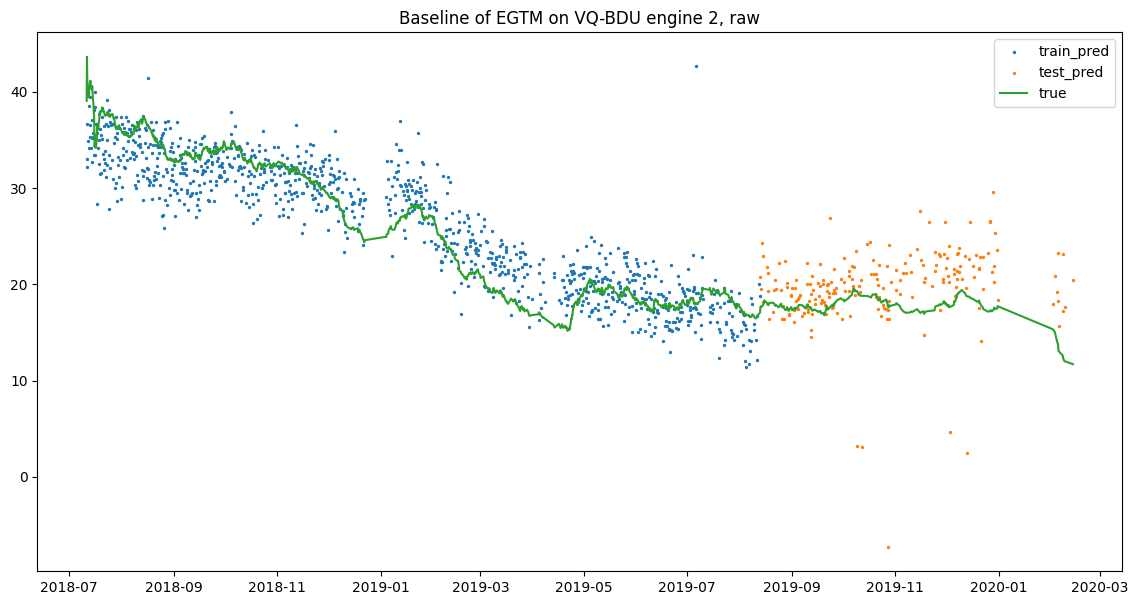

In [44]:
plot_predictions(data.reset_index(), 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=False, title="Baseline of EGTM on VQ-BDU engine 2, raw")

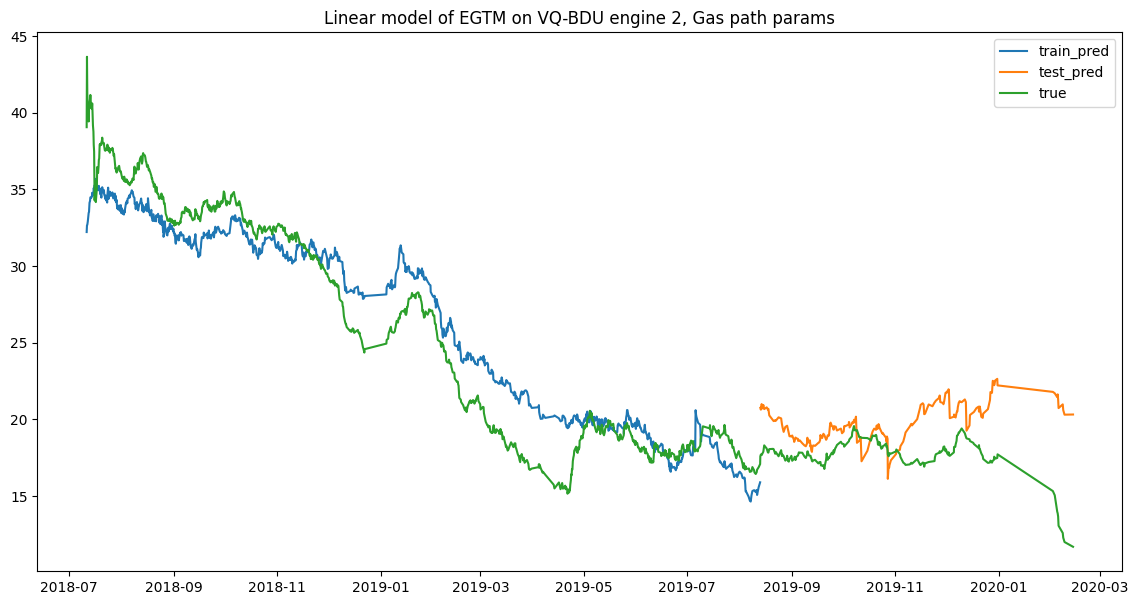

In [45]:
plot_predictions(data.reset_index(), 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True)

### Baseline на отобранных признаках

In [46]:
X = dataset[selected_params]
y = dataset['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 4.10057, 'mae': 3.26269, 'r2': -2.04237, 'mape': 0.16073}

In [47]:
X = dataset[selected_params].copy()
X['epr'] = dataset['p5']
y = dataset['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 4.10068, 'mae': 3.26365, 'r2': -2.04253, 'mape': 0.16079}

In [48]:
X['ecr'] = dataset['p25'] / dataset['p5']
(dataset['p5'] == 0).sum()

0

In [49]:
from sklearn.metrics import r2_score

def exp_mean(series: pd.DataFrame):
  return pd.Series(series).ewm(alpha=1 / 40).mean().to_list()

r2_score(y_test, exp_mean(predicted_test))

-0.8421610354697777

In [50]:
data = dataset.copy(deep=False)
data['train_pred'] = predicted_train.tolist() + ([None] * (len(data) - train_i))
data['test_pred'] = ([None] * train_i) + predicted_test.tolist()

data['exp_train_pred'] = exp_mean(predicted_train) + ([None] * (len(data) - train_i))
data['exp_test_pred'] = ([None] * train_i) + exp_mean(predicted_test)

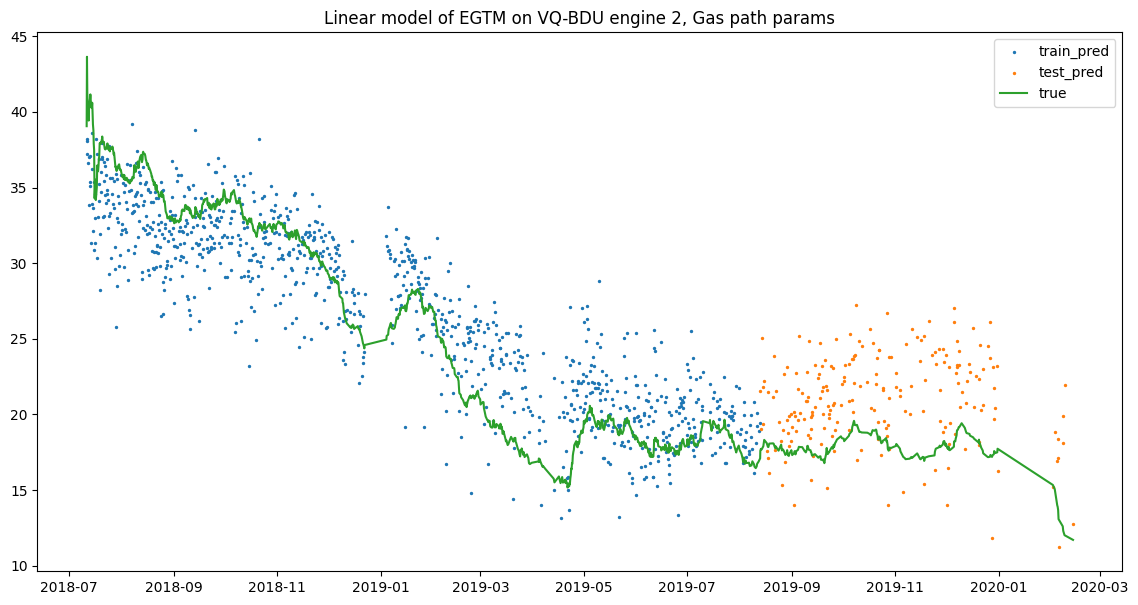

In [51]:
plot_predictions(data.reset_index(), 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=False)

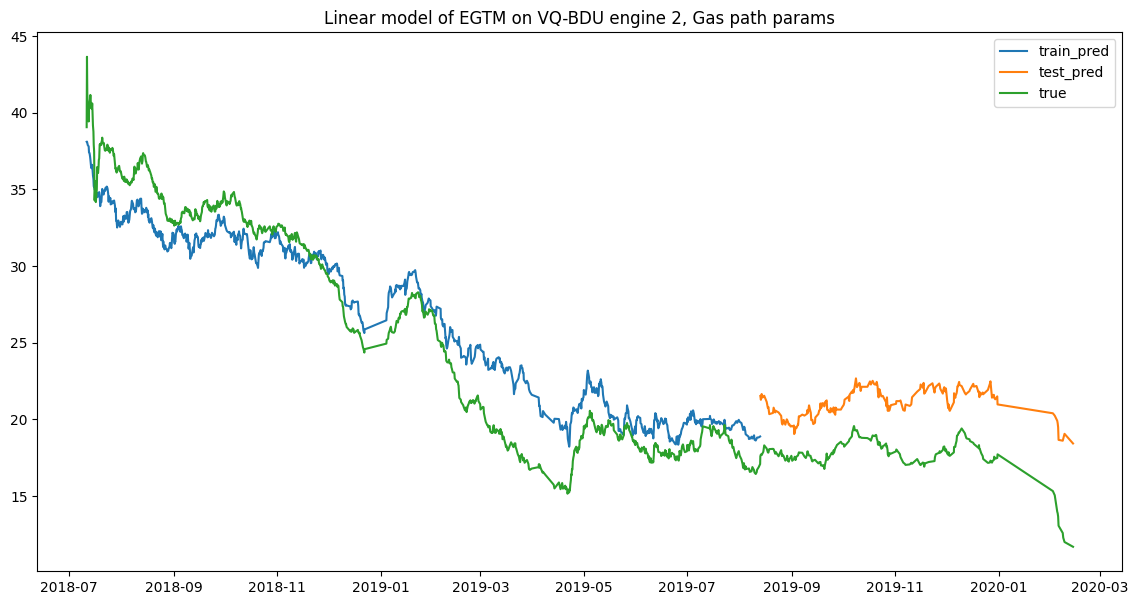

In [52]:
plot_predictions(data.reset_index(), 'VQ-BDU', 2, train_i, predicted_test, predicted_train)

### Фильтрация записей: оставить только записи где WAI, NAI, PRV, HPV, XF == 0

In [53]:
data_filtered = dataset[(dataset['wai'] == 0) & (dataset['nai'] == 0) & (dataset['prv'] == 0) & (dataset['hpv'] == 0) & (dataset['xf'] == 0)]
data_filtered.shape[0]

1431

Получили 1515 записей после фильтрации, это примерно половина датасета

In [54]:
X = data_filtered[selected_params]
y = data_filtered['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 3.66549, 'mae': 2.95838, 'r2': -2.14622, 'mape': 0.14895}

In [55]:
selected_params = ['wai', 'nai', 'prv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

X = data_filtered[selected_params]
y = data_filtered['egtm']


metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 3.66549, 'mae': 2.95838, 'r2': -2.14622, 'mape': 0.14895}

Результат модели улучшился: **RMSE 4.06573 -> 3.6858**

Построим аналогичный сглаженный график

In [56]:
data = data_filtered.copy(deep=False)
data['train_pred'] = predicted_train.tolist() + ([None] * (len(data) - train_i))
data['test_pred'] = ([None] * train_i) + predicted_test.tolist()

data['exp_train_pred'] = exp_mean(predicted_train) + ([None] * (len(data) - train_i))
data['exp_test_pred'] = ([None] * train_i) + exp_mean(predicted_test)

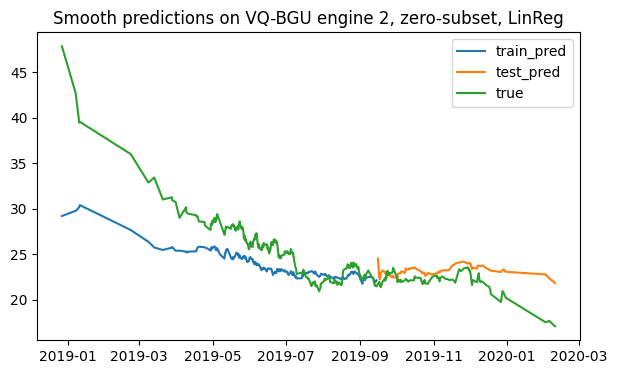

In [57]:
sub = data[(data['acnum'] == 'VQ-BGU') & (data['pos'] == 2)]

plt.figure(figsize=(7, 4))
plt.plot(sub['reportts'], sub['exp_train_pred'], '-')
plt.plot(sub['reportts'], sub['exp_test_pred'], '-')
plt.plot(sub['reportts'], sub['egtm'], '-')

plt.legend(['train_pred', 'test_pred', 'true'])
plt.title("Smooth predictions on VQ-BGU engine 2, zero-subset, LinReg")
plt.show()

Из графика не видно значительных улучшений

### Применим градиентный бустинг

In [58]:
X = dataset[selected_params]
y = dataset['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, model='gradboost')

metrics

{'rmse': 6.50484, 'mae': 4.92036, 'r2': -6.6559, 'mape': 0.24867}

no luck :/

In [59]:
data = dataset.copy(deep=False)
data['train_pred'] = predicted_train.tolist() + ([None] * (len(data) - train_i))
data['test_pred'] = ([None] * train_i) + predicted_test.tolist()

data['exp_train_pred'] = exp_mean(predicted_train) + ([None] * (len(data) - train_i))
data['exp_test_pred'] = ([None] * train_i) + exp_mean(predicted_test)

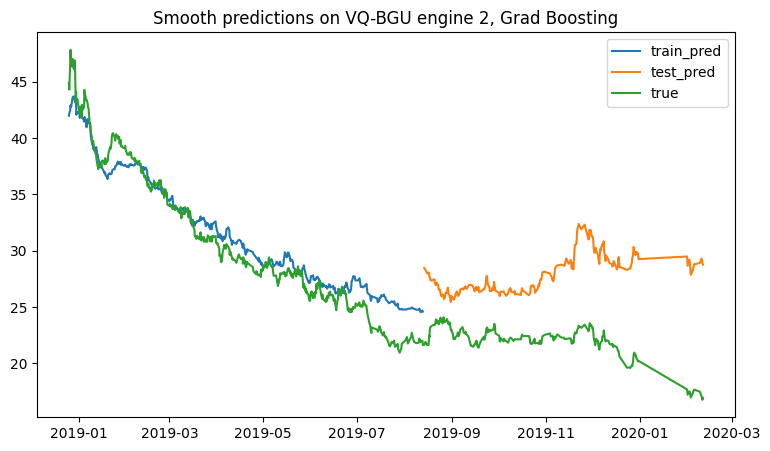

In [60]:
plot_predictions(data.reset_index(), 'VQ-BGU', 2, train_i, 
                 predicted_test, predicted_train, 
                 figsize=(9, 5),
                 title="Smooth predictions on VQ-BGU engine 2, Grad Boosting")

Результат: 

0. Экспоненциальное сглаживание делает кривую визуально более похожей на настоящие значения
1. Отобранные параметры газодинамики дают лучший результат, чем baseline на большом наборе параметров: \
    **RMSE 5.170 -> 4.065** (см. ноутбук от 23 дек.)
3. Фильтрация датасета где bool-признаки == 0 даёт прирост в точности \
    **RMSE 4.06573 -> 3.6858**
2. Градиентный бустинг работает хуже линейной модели